# Low-Vol systematic trading strategy

The strategy aims at benefiting from the low-volatility anomaly, where the standard positive relationship between returns and volatility does not hold. The final portfolio invests in securities with the lowest annual volatility. The sample of stocks is divided into five quantiles based on the total volatility of the previous year and rebalanced monthly. 

In [1]:
import os
notebook_path = os.getcwd()
print(notebook_path)

/Users/stefanogrillini/Documents/Python/Coursera/EDHEC_Coursera_notebooks_and_codem01_v02/nb/My Strategies


In [2]:
path = "/Users/stefanogrillini/Documents/GitHub/Low-Vol-systematic-strategy/"
os.chdir(path)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import date
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import math
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')
import my_risk_kit as erk

We fetch the names and Adjusted Closing Prices of the first 100 securities listed in the S&P 500 index as well as the benchmark.
Then we drop companies with missing data. 

In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])

In [5]:
data = pd.DataFrame(columns = sp500_list[:100])
for i in data.columns:
    data[i] = yf.download(
    i, 
    start='2016-01-05', 
    end=date.today(),
    progress = False
)['Adj Close']

symbol_benchmark = "^SPX"
benchmark = yf.download(
    symbol_benchmark, 
    start='2016-01-05', 
    end=date.today()
)['Adj Close']


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


In [6]:
for col in data:
   if data[col].isna().sum() > 0:
      print(col)

BRK.B
BF.B
CARR


In [7]:
benchmark.isnull().values.any()

False

In [8]:
data.drop(['BRK.B','BF.B', 'CARR'], axis=1, inplace = True)
           
           
         #  , 'CDAY', 'CEG', 'CTVA', 'DOW', 'FTV'
         #  , 'FOXA', 'FOX', 'GEHC', 'HWM', 'IR', 'INVH', 'KVUE', 'LW'
         #  , 'MRNA', 'OGN', 'OTIS', 'VICI'], axis=1, inplace = True)

No we report some summary statistics and we compare the comulative performance of the S&P 500 Index vs a simple equally weighted average of the first 100 stocks.

In [31]:
# Some summary stats of the selected stocks
returns = data.pct_change().shift(1)
returns.dropna(inplace = True)
bench_ret = benchmark.pct_change().shift(1)
erk.summary_stats(returns, riskfree_rate=0.04/250, periods_per_year=250)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
MMM,-0.008416,0.243883,-0.384027,12.384401,0.023999,0.037701,-0.035157,-0.560702
AOS,0.105969,0.277893,0.310010,7.451706,0.025186,0.039596,0.380693,-0.468063
ABT,0.139127,0.244812,-0.156041,9.846142,0.023361,0.035928,0.567558,-0.316732
ABBV,0.178355,0.265033,-0.664680,15.713002,0.025494,0.039147,0.672243,-0.450898
ACN,0.180814,0.255247,0.214703,9.686934,0.022574,0.038695,0.707651,-0.396878
...,...,...,...,...,...,...,...,...
CDW,0.252635,0.296904,-0.306176,11.455830,0.028198,0.043622,0.850223,-0.448341
CE,0.109959,0.326892,-0.399689,10.563345,0.032497,0.048325,0.335833,-0.533295
COR,0.087743,0.284180,-0.009021,10.409315,0.026417,0.042438,0.308147,-0.317552
CNC,0.086027,0.354327,-0.112090,10.477223,0.033597,0.050922,0.242301,-0.418165


In [32]:
# Let's start with a simple equally-weighted portfolio
ew_average = returns.mean(axis=1)
ew_portfolio = pd.DataFrame({'SP500': bench_ret, 'Equally-weighted average': ew_average}, index = returns.index)
ew_portfolio.isnull().values.any()

False

In [34]:
ew_portfolio.corr()

,SP500,Equally-weighted average
SP500,1.000000,0.967402
Equally-weighted average,0.967402,1.000000


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.108455,0.187808,-0.543175,17.860274,0.017256,0.029285,0.350519,-0.339250
Equally-weighted average,0.164973,0.197833,-0.577960,18.923450,0.017842,0.030332,0.607494,-0.383103


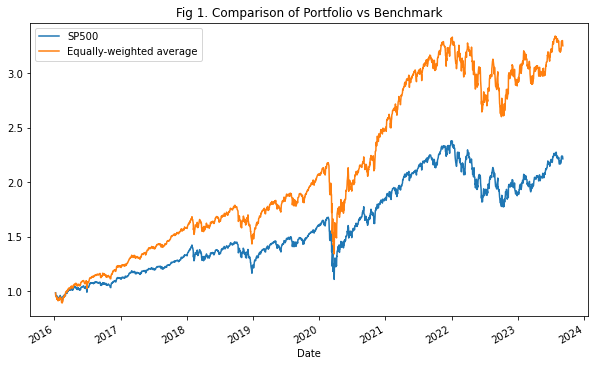

In [13]:
(1+ew_portfolio).cumprod().plot(figsize=(10,6), title="Fig 1. Comparison of Portfolio vs Benchmark")
erk.summary_stats(ew_portfolio.dropna(), riskfree_rate=0.04, periods_per_year=250)

Overall, a simple portfolio with equally weighted returns for the first 100 stocks of the S&P 500 Index yields better performances. In the literature this is explained by the overweight that some stocks have in the index such that its performances are mainly driven by the performances of the top contributors. 

In [14]:
# Convert from daily to monthly prices using 'M'
data_monthly = data.resample('M').last()

# Drop the columns with insufficient data
data_monthly_clean = data_monthly.dropna(axis=1)

In [15]:
data_monthly_clean.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AES,...,CCL,CTLT,CAT,CBOE,CBRE,CDW,CE,COR,CNC,CNP
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,116.267067,30.848160,32.970310,39.661057,93.252792,32.943642,28.415316,89.129997,70.415237,7.392312,...,42.007359,23.530001,51.135277,64.219376,27.969999,35.204678,53.964760,79.067108,31.030001,13.624856
2016-02-29,121.659546,31.192015,33.745567,39.451553,88.587517,29.963385,28.358229,85.150002,71.771187,7.625751,...,42.139805,24.270000,55.621113,60.247837,25.410000,36.340031,51.413242,76.769905,28.480000,14.405095
2016-03-31,129.228836,33.820156,36.437218,41.264835,101.964897,32.276989,29.453306,93.800003,76.499680,9.182030,...,46.366085,26.670000,62.883911,63.205482,28.820000,38.102863,55.809860,76.707870,30.785000,16.175772
2016-04-30,129.810486,34.326408,34.091961,44.491295,100.742386,32.877895,32.397831,94.220001,75.416687,8.768778,...,43.097519,29.530001,64.475975,59.945076,29.629999,35.348446,60.545410,75.422745,30.980000,16.585581
2016-05-31,131.408768,36.584599,34.731731,45.898945,106.139923,37.446648,34.972229,99.470001,74.905037,8.713779,...,42.237331,28.120001,60.153793,61.580124,29.850000,39.175205,60.357018,66.755577,31.174999,17.627279


## Build Low Vol indicator and loop across all dates

In [16]:
monthly_returns = data_monthly_clean.pct_change().shift(1)
monthly_returns = monthly_returns.dropna(axis=0)

# Low Vol indicator
vol_12 = data_monthly_clean.pct_change().rolling(window=12).std()
# Drop the 1 or 2 rows with NA's
vol_12 = vol_12.dropna(axis=0)

In [36]:
# Low Vol indicator using EWMA, with decay factor alpha = 0.94
vol_ewma_12 = data_monthly_clean.pct_change().ewm(alpha = 0.94).std()
# Drop the 1 or 2 rows with NA's
vol_ewma_12 = vol_ewma_12.dropna(axis=0)

In [44]:
# Create a df for volatility ranks
vol_ranks = pd.DataFrame(index=vol_12.index, columns=vol_12.columns)

In [45]:
# Place each stock in a "quintile" bucket, at each "date" (rows)
for date in vol_ranks.index:
    row_values = vol_12.loc[date] # looping values each row
    ranks = pd.Series(row_values).rank(method='max') # set rank at each row
    quintiles = pd.qcut(ranks, q=5, labels=False) # divide into quintiles

    # Create dataframe with ranks for each stock at each month(4=high, 0=low)
    vol_ranks.loc[date] = quintiles 

In [46]:
quintile_dfs = {}
vol_returns = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns[quintile] = quintile_dfs[quintile].mean(axis=1).dropna()

In [47]:
vol_returns.rename(columns = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Medium', 3: 'High Vol', 4: 'Very High Vol'}, inplace = True)
vol_returns.head()

,Very Low Vol,Low Vol,Medium,High Vol,Very High Vol
Date,,,,,
2016-03-31,0.054686,0.061145,0.091288,0.103618,0.115813
2016-04-30,0.031159,0.028456,0.013300,-0.025896,0.006906
2016-05-31,0.018527,0.012423,0.025786,0.022613,0.083714
2016-06-30,0.024166,0.009450,0.021378,0.010010,-0.078791
2016-07-31,0.020345,0.021397,0.041347,0.046916,0.108693


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Very Low Vol,0.106876,0.088733,-0.758640,3.892523,0.037833,0.054201,0.726978,-0.190646
Low Vol,0.122027,0.128453,-0.541304,3.991908,0.055062,0.083880,0.615872,-0.235778
Medium,0.170559,0.158815,-0.536050,3.566379,0.066915,0.096091,0.792905,-0.195683
High Vol,0.178601,0.209238,-0.646756,3.952981,0.092593,0.128137,0.638743,-0.256733
Very High Vol,0.255329,0.359929,-0.515477,5.377029,0.154939,0.215151,0.576521,-0.452040


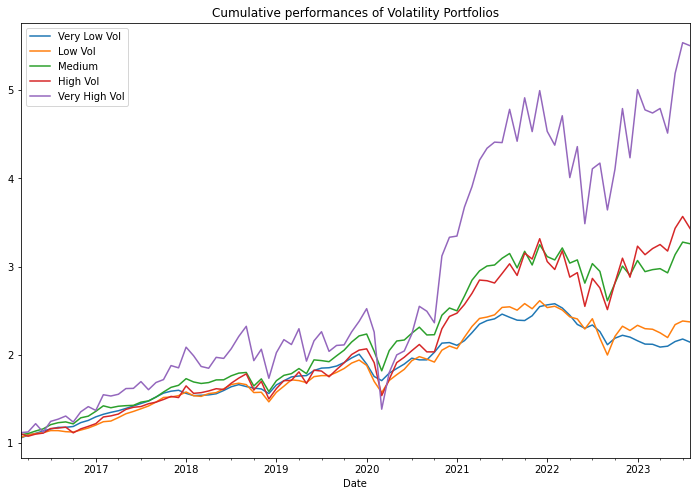

In [48]:
# Plot the cumulative return
(1+vol_returns).cumprod().plot(figsize = (12, 8), title = "Cumulative performances of Volatility Portfolios")
erk.summary_stats(vol_returns, riskfree_rate=0.04, periods_per_year=12)

In [22]:
# Convert from daily to monthly also the SP500
bench_monthly = benchmark.resample('M').last()
bench_ret_monthly = bench_monthly.pct_change()
bench_ret_monthly.isnull().values.any()

True

In [23]:
vol_ranks.columns[vol_ranks.iloc[-1] == 4]

Index(['ALK', 'ALB', 'ALGN', 'AMZN', 'AMD', 'AAL', 'APA', 'AMAT', 'APTV',
       'ANET', 'AXON', 'BKR', 'BBY', 'BWA', 'BXP', 'CZR', 'COF', 'CCL', 'CTLT',
       'CAT'],
      dtype='object')

In [24]:
bench_ret_monthly.dropna(inplace = True)

In [25]:
low_vol_df = pd.DataFrame({'SP500': bench_ret_monthly, 'Low Vol Portfolio': vol_returns['Very Low Vol']}, index = vol_returns.index)
low_vol_df.dropna(inplace = True)

In [26]:
low_vol_df.describe()

,SP500,Low Vol Portfolio
count,81.000000,81.000000
mean,0.010039,0.012196
std,0.047773,0.030368
min,-0.125119,-0.074844
25%,-0.011137,-0.004949
50%,0.017924,0.017573
75%,0.036022,0.033081
max,0.126844,0.078087


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SP500,0.112211,0.165490,-0.496735,3.398506,0.074156,0.096472,0.420688,-0.247695
Low Vol Portfolio,0.150331,0.105197,-0.682109,3.642924,0.042642,0.060794,1.011733,-0.123801


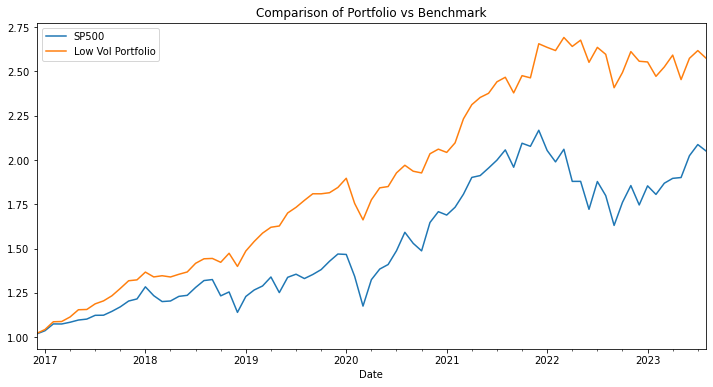

In [27]:
(1+low_vol_df).cumprod().plot(figsize=(12,6), title="Comparison of Portfolio vs Benchmark")
erk.summary_stats(low_vol_df.dropna(), riskfree_rate=0.04, periods_per_year=12)

The momentum signal for the portfolio improves the performances, with 30% annualized returns vs 5.8%, SR>1, lower drawdown and lower VaR. However, there is higher volatility. Next step is to make the portofolio market neutral. 

# Test the portfolio vs Fama - French 3 factor model + Carhart momentum

In [28]:
ff4 = gff.carhart4Factor(frequency = 'm')
ff4.rename(columns = {'date_ff_factors': 'Date'}, inplace = True)
ff4.set_index('Date', inplace = True)
ff4 = ff4['2016-05-01':]
ff4.head()

,Mkt-RF,SMB,HML,RF,MOM
Date,,,,,
2016-05-31,0.0178,-0.0017,-0.0166,0.0001,0.0142
2016-06-30,-0.0005,0.0061,-0.0148,0.0002,0.0413
2016-07-31,0.0395,0.0249,-0.0132,0.0002,-0.0334
2016-08-31,0.0049,0.0115,0.0318,0.0002,-0.0349
2016-09-30,0.0025,0.0212,-0.0124,0.0002,0.0019


In [29]:
ff_test = pd.concat([low_vol_df['Low Vol Portfolio'], ff4], axis=1)
monthly_returns
ff_test.dropna(axis = 0, inplace = True)

In [30]:
y, x = ff_test[['Low Vol Portfolio']], ff_test[['Mkt-RF', 'SMB', 'HML', 'MOM']]
x = sm.add_constant(x) 
est = sm.OLS(y, x).fit() 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Low Vol Portfolio   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     57.37
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           4.45e-22
Time:                        16:45:44   Log-Likelihood:                 222.54
No. Observations:                  80   AIC:                            -435.1
Df Residuals:                      75   BIC:                            -423.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.002      3.845      0.000       0.003       0.010
Mkt-RF         0.5559      0.040     13.927      0.000       0.476       0.635
SMB           -0.3251      0.069     -4.695      0.000      -0.463      -0.187
HML            0.1182      0.043      2.752      0.007       0.033       0.204
MOM            0.0545      0.051      1.071      0.287      -0.047       0.156
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.601
Skew:                          -0.058   Prob(JB):                        0.165
Kurtosis:                       4.033   Cond. No.                         41.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""